In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns

from diagnostics.paper_utils import plot_scatters, create_subtitle
from diagnostics.paper_utils import plot_metric_bars_and_scatters_labeled
from diagnostics.paper_utils import plot_metric_bars_and_scatters_video
from diagnostics.paper_utils import plot_metric_vs_pixerror_scatters
from diagnostics.paper_utils import plot_metric_vs_metric_scatters

In [2]:
sns.set_style('white')
dataset_name = "mirror-mouse"
df_save_path = "/home/mattw/Dropbox/shared/litpose_results/%s" % dataset_name

In [3]:
# df_labeled_preds = pd.read_parquet(
#     os.path.join(df_save_path, "%s_labeled_preds.pqt" % dataset_name))
df_labeled_metrics = pd.read_parquet(
    os.path.join(df_save_path, "%s_labeled_metrics.pqt" % dataset_name))
# df_video_preds = pd.read_parquet(
#     os.path.join(df_save_path, "%s_video_preds.pqt" % dataset_name))
df_video_metrics = pd.read_parquet(
    os.path.join(df_save_path, "%s_video_metrics.pqt" % dataset_name))

# Plots on labeled data

### basic metrics for each model type

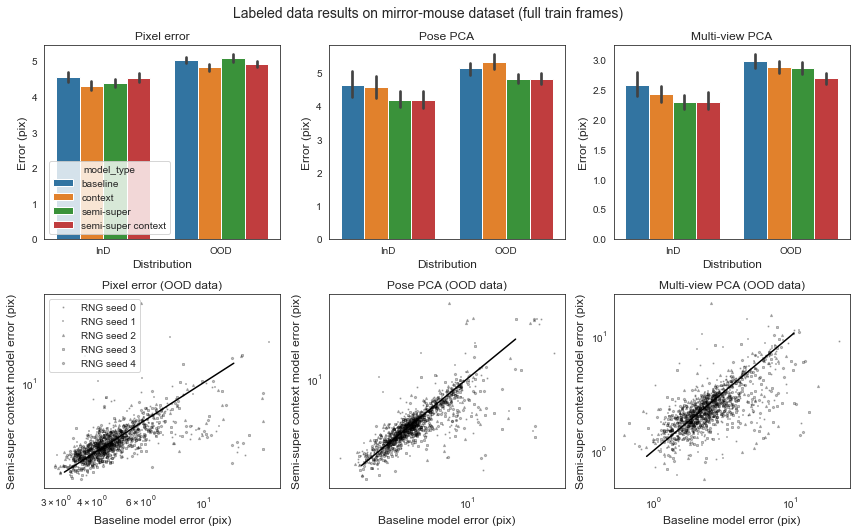

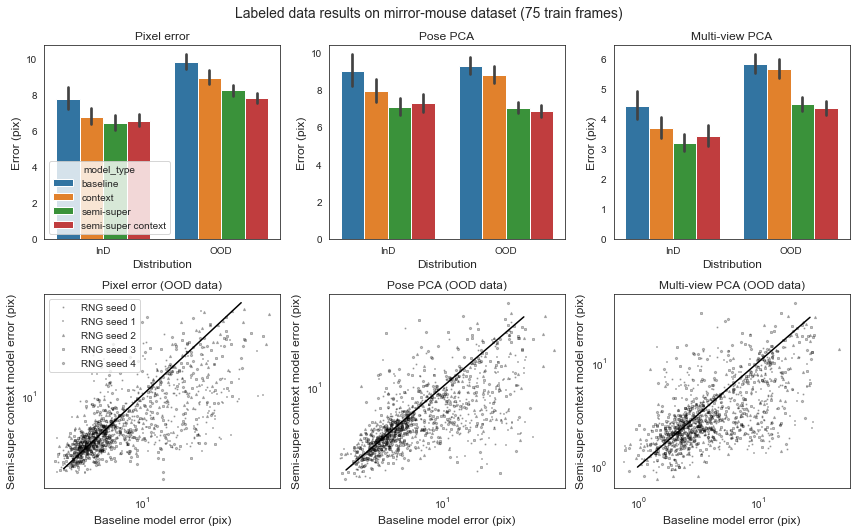

In [4]:
# take mean over points, variability over seeds
keypoint = 'mean'
split_set = 'test'  # 'test' is only value for which InD and OOD both have results
train_frames = '75'  # '75' | '1'   
models_to_compare = ['baseline', 'semi-super context']

for train_frames in ['1', '75']:
    train_frame_str = 'full train frames' if train_frames == '1' \
        else '%s train frames' % train_frames
    title = 'Labeled data results on %s dataset (%s)' % (dataset_name, train_frame_str)
    plot_metric_bars_and_scatters_labeled(
        df_labeled_metrics, models_to_compare, keypoint, train_frames, split_set, pix_thresh=0,
        title=title, display_plot=True)

### pixel error vs metric scatters

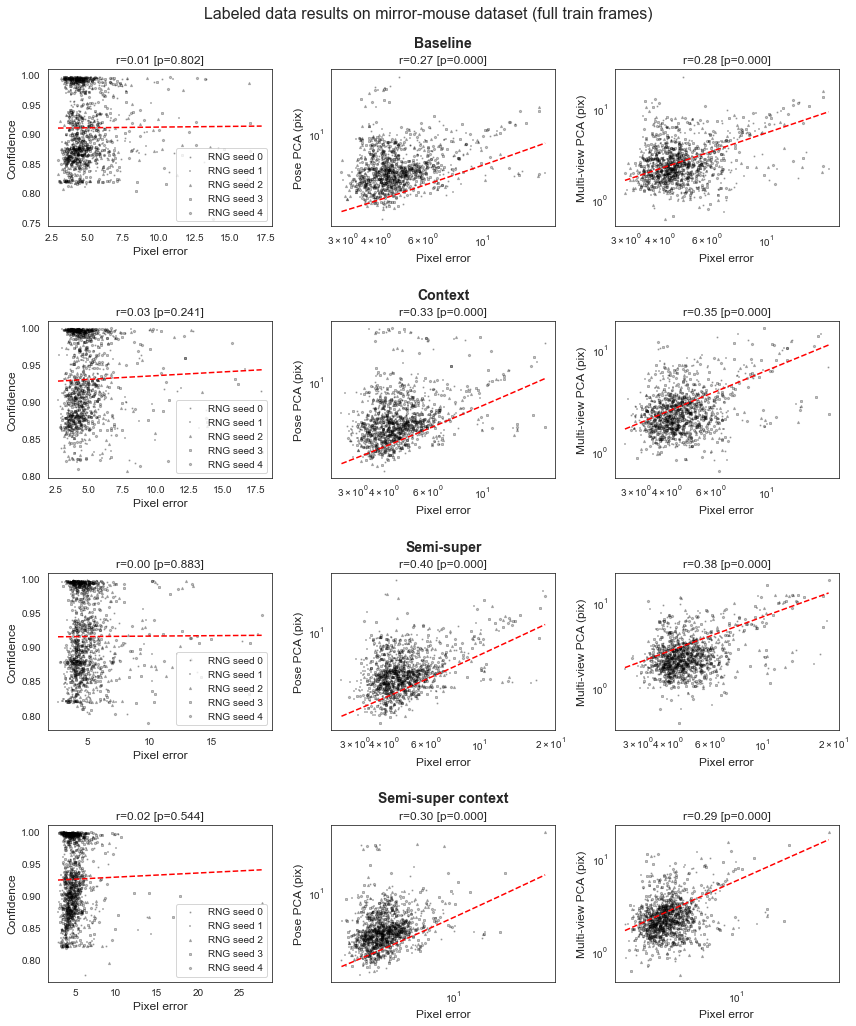

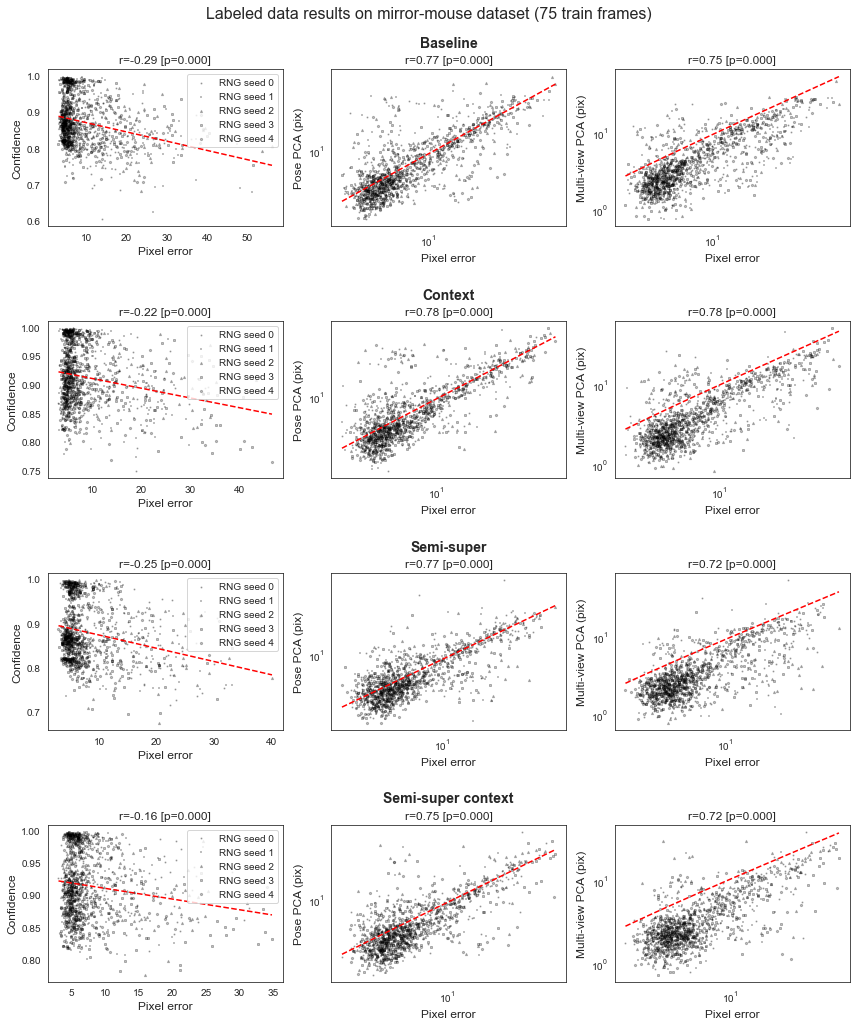

In [5]:
models_to_compare = ['baseline', 'context', 'semi-super', 'semi-super context']
for train_frames in ['1', '75']:
    train_frame_str = 'full train frames' if train_frames == '1' \
        else '%s train frames' % train_frames
    title = 'Labeled data results on %s dataset (%s)' % (dataset_name, train_frame_str)
    plot_metric_vs_pixerror_scatters(
        df_labeled_metrics, models_to_compare, keypoint, train_frames, split_set, 
        title=title, display_plot=True)

### confidence vs metric scatters

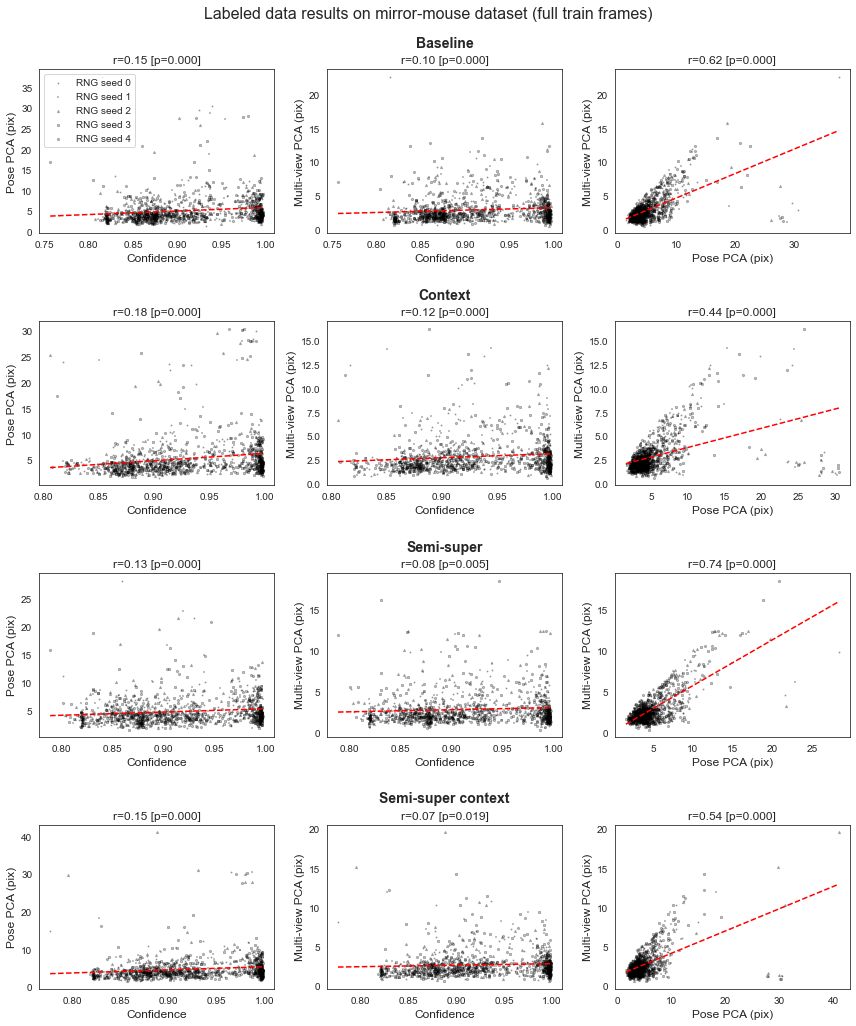

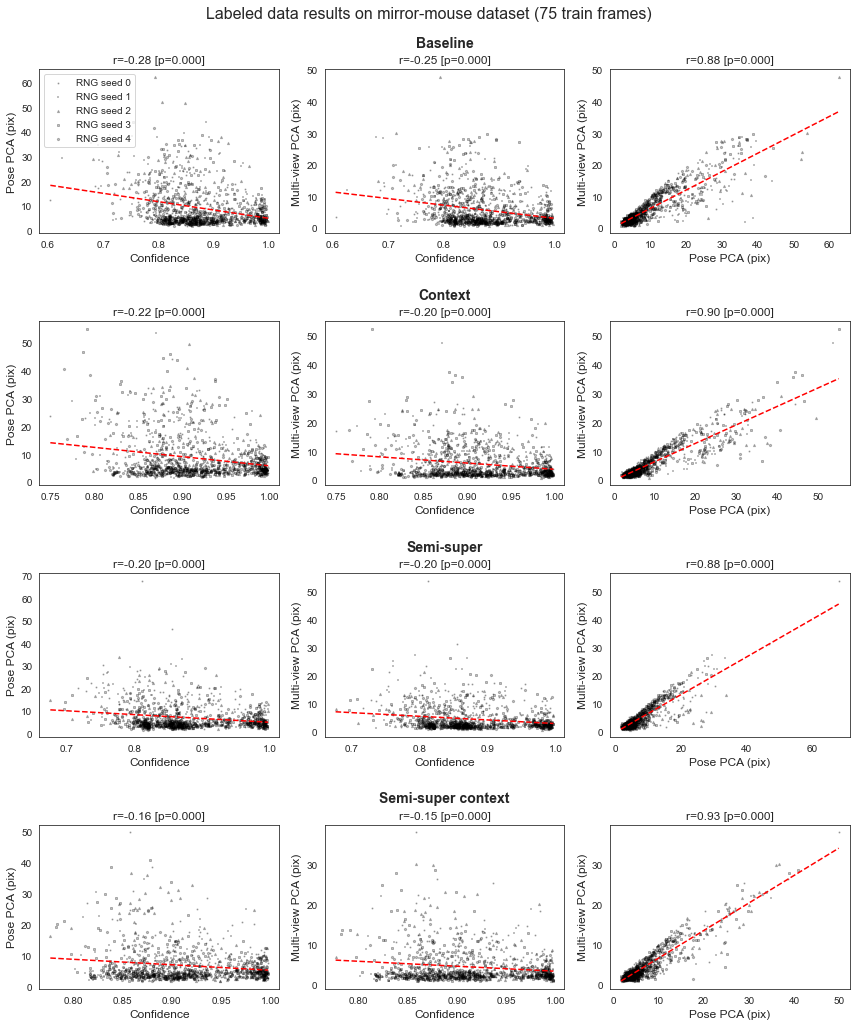

In [6]:
models_to_compare = ['baseline', 'context', 'semi-super', 'semi-super context']
for train_frames in ['1', '75']:
    train_frame_str = 'full train frames' if train_frames == '1' \
        else '%s train frames' % train_frames
    title = 'Labeled data results on %s dataset (%s)' % (dataset_name, train_frame_str)
    plot_metric_vs_metric_scatters(
        df_labeled_metrics, models_to_compare, keypoint, train_frames, split_set, 
        title=title, display_plot=True)

# Plots on unlabeled data

In [7]:
df_video_metrics_gr = df_video_metrics.groupby([
    'metric', 'video_name', 'model_path', 'rng_seed_data_pt', 'train_frames', 'model_type']
).mean().reset_index().set_index('video_name')

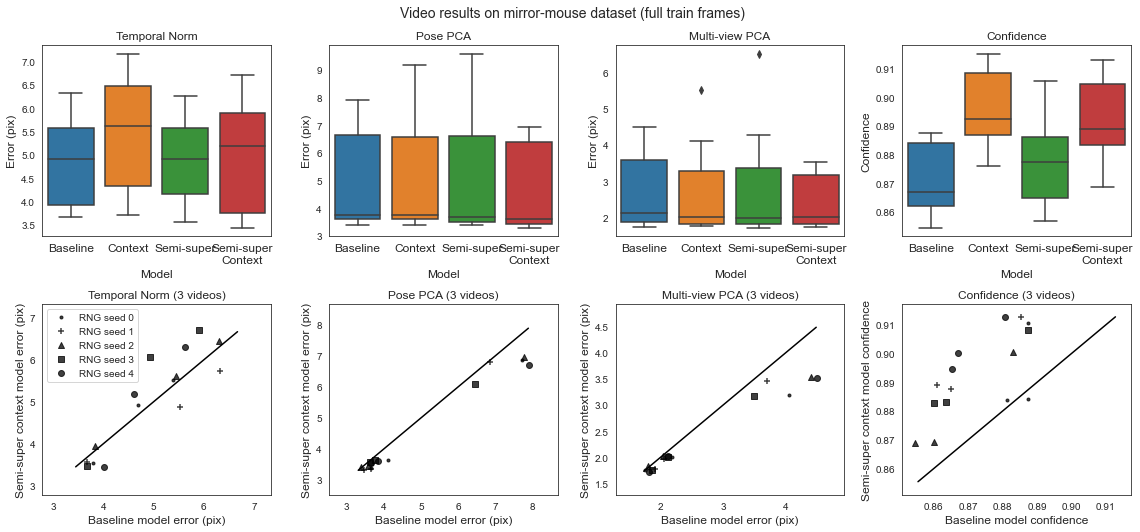

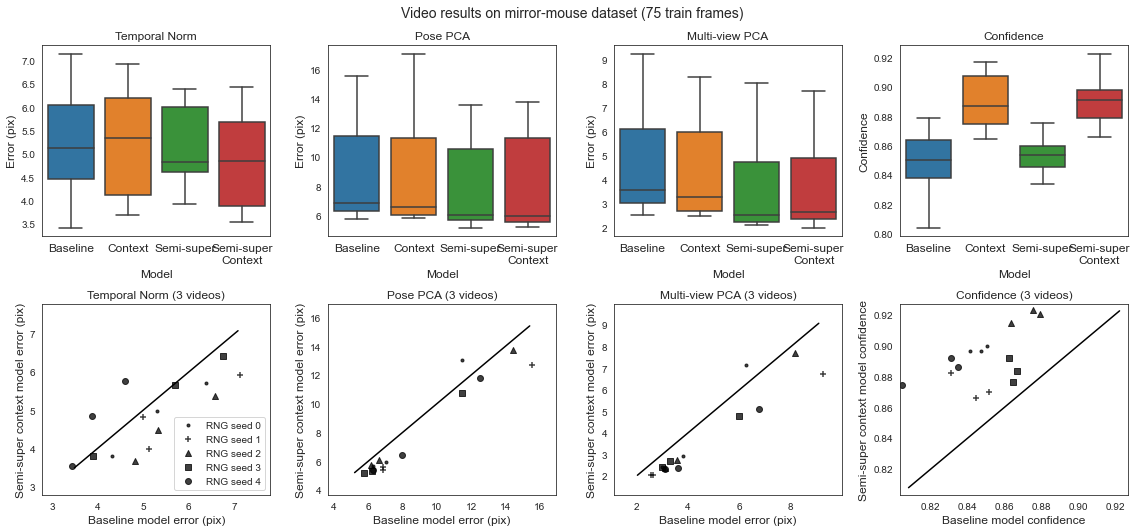

In [9]:
models_to_compare = ['baseline', 'semi-super context']

for train_frames in ['1', '75']:
    train_frame_str = 'full train frames' if train_frames == '1' \
        else '%s train frames' % train_frames
    title = 'Video results on %s dataset (%s)' % (dataset_name, train_frame_str)
    plot_metric_bars_and_scatters_video(
        df_video_metrics_gr, models_to_compare, keypoint, train_frames,
        title=title, display_plot=True)